In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

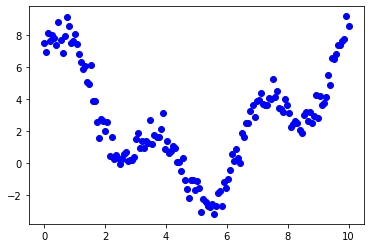

In [2]:
n = 150
X_data = np.linspace(0,10,n)
X_data = X_data.reshape((n,1))
Y_data = np.sin(X_data) + 2* np.sin(2 * X_data) + 0.3 * (X_data - 5)**2 
data_no_noise = np.concatenate((X_data, Y_data), axis=1)

Y_data += np.random.normal(0, 0.5, [n,1])

plt.plot(X_data, Y_data, 'bo')
plt.show()

In [3]:
data = np.concatenate((X_data, Y_data), axis=1)
data_eval = data.copy()

np.random.shuffle(data)

data_tr, data_val, data_test = np.split(data, [int(0.8*n), int(0.8*n)+int(0.1*n)], axis = 0)
print(data_tr.shape, data_val.shape, data_test.shape)
n_tr, n_val, n_test = data_tr.shape[0], data_val.shape[0], data_test.shape[0]

(120, 2) (15, 2) (15, 2)


In [4]:
def next_batch(data_tr, i, batch_size):
    return data_tr[i*batch_size:(i+1)*batch_size-1, :]  

In [5]:
# Parameters
num_epochs = 4000
batch_size = n_tr // 1
itpep = n_tr // batch_size
# display_step = 100
wd_par = 0.1
lrs = np.linspace(1e-3, 0.1, 10) 

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 1 
num_output = 1 

# tf Graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])

In [6]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

In [7]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer 
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

In [8]:
fp = neural_net(X)

error = tf.reduce_sum(tf.pow(fp-Y, 2))

loss = n_tr / batch_size * tf.reduce_sum(tf.pow(fp-Y, 2)) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])

W0908 14:51:58.498428 17140 deprecation.py:323] From C:\Users\afpsa\Anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Optimization for learning rate 0.001000 finished!
Optimization for learning rate 0.012000 finished!
Optimization for learning rate 0.023000 finished!
Optimization for learning rate 0.034000 finished!
Optimization for learning rate 0.045000 finished!
Optimization for learning rate 0.056000 finished!
Optimization for learning rate 0.067000 finished!
Optimization for learning rate 0.078000 finished!
Optimization for learning rate 0.089000 finished!
Optimization for learning rate 0.100000 finished!


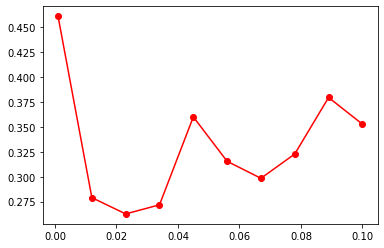

In [9]:
lr_errors = []
opt_weights = []
opt_biases = []

sess = tf.Session()
for learning_rate in lrs:
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    train_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    #############################################################
    sess.run(init)
    #############################################################
    i = 0

    for iteration in range(num_epochs * itpep):

        data_batch = next_batch(data_tr, i, batch_size)
        sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]]})

        if (iteration + 1) % itpep == 0:
            i = 0
        else:
            i += 1
    print('Optimization for learning rate', '{:.6f}'.format(learning_rate), 'finished!')
    
    lr_errors.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}) / data_val.shape[0])
    opt_weights.append(sess.run(weights))
    opt_biases.append(sess.run(biases))
    
plt.plot(lrs, lr_errors, 'ro-')
plt.show()

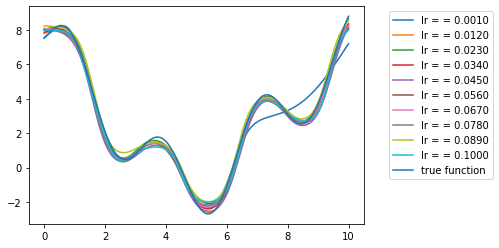

In [10]:
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'lr = = %.4f' %lrs[c])
    
plt.plot(data_no_noise[:, [0]], data_no_noise[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

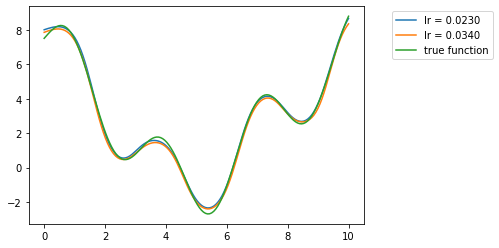

In [13]:
from more_itertools import sort_together

sorted_weights = list(sort_together([lr_errors, opt_weights])[1])
sorted_biases = list(sort_together([lr_errors, opt_biases])[1])
sorted_lrs = list(sort_together([lr_errors, lrs])[1])

for c in range(2):
    weights = sorted_weights[c]
    biases = sorted_biases[c]
    fp = neural_net(X)
    
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'lr = %.4f' %sorted_lrs[c])
    
plt.plot(data_no_noise[:, [0]], data_no_noise[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()
